In [114]:
import os, sys, time

sys.path
sys.path.append('./')

import numpy as np
from astropy import wcs
from astropy.io import fits
import csv


import matplotlib
matplotlib.use('PDF')
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
# import aplpy
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import interp1d


import nbimporter
import function as f
import gauss as g
from main import spectraAna

### **STEP 1**. Open FITS image cube

In [115]:
## Open FITS image cube
fitscubename = '/home/tcc/data/cool_region/cool_spw0.fits'
s = spectraAna(fitscubename = fitscubename)
s.readfits(verbose = False)

naxis1   = s.naxis1
naxis2   = s.naxis2
ctype3   = s.ctype3
naxis3   = s.naxis3
crpix3   = s.crpix3
cdelt3   = s.cdelt3
crval3   = s.crval3 
restfreq = s.restfreq
cube     = s.cube  ## all intensity 


## Create the frequency array based on the third axis
if ctype3 == 'VELO-LSR':
    velocity_array = np.zeros( naxis3 )
    velocity_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3
    
    c = 299792458
    freq_array = restfreq * (1 - velocity_array / c)

elif cytpe3 == 'FREQ':
    freq_array = np.zeros( naxis3 )
    freq_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3

### **STEP 2**.  Fitting the spectra using `gausspy`.
***STEP 2-1.*** Fit

In [ ]:
rms_spw0 = 0.0018148618
rms_spw1 = 0.0017738817
rms_spw2 = 0.0025416217
rms_spw3 = 0.0018573649

# FITS -> Gausspy set
g.transdata(
             cube = cube, velo=velocity_array, freq=freq_array,
             spw_id = '0',
             rms = rms0, base = 'freq',
             xrange1 = 95, xrange2 = 101,
             yrange1 = 70, yrange2 = 76
            )

g.decompose(spw_id = '0')
#g.plotfig()

***STEP 2-2***. Classify the results to the dictionary **fresult_dic**.   

There are two parameters in this dictionary, 'loc' and 'fitting'. The former notes the location, while the latter notes the fitting results with three different type, 's', 'm', and 'f'.  

    - 's': Fit with one gaussian component   
    - 'm': Fit with multiple gaussian components : write to the file **multifit_loc_0.csv**   
    - 'f': Failed : write to the file **failfit_loc_0.csv**

In [117]:
data = pickle.load(open('cube_0.pickle','rb'))
data_decomposed = pickle.load(open('cube_decomposed_0.pickle','rb'))

fresult_dic = {}

#print(restfreq/1e9)

for i in range(len(data_decomposed['means_fit'])): # i = pixel number(not components in each pixel)
    ff_in_each_pixel = data_decomposed['means_fit'][i]
    loc = tuple(data['location'][i]) # loc = (x, y)
    
    if len(ff_in_each_pixel) == 0: #check fitting
        string = 'f'
        fresult_dic['loc'] = fresult_dic.get('loc', []) + [loc]
        fresult_dic['fitting'] = fresult_dic.get('fitting', []) + [string]
        
    elif len(ff_in_each_pixel) == 1:
        string = 's'
        fresult_dic['loc'] = fresult_dic.get('loc', []) + [loc]
        fresult_dic['fitting'] = fresult_dic.get('fitting', []) + [string]
        
    elif len(ff_in_each_pixel) > 1:
        #print(len(ff_in_each_pixel))
        string = 'm'
        fresult_dic['loc'] = fresult_dic.get('loc', []) + [loc]
        fresult_dic['fitting'] = fresult_dic.get('fitting', []) + [string]
    
    

Multiple gaussian components

In [74]:
multi_locs = [] 

for i in range(len(fresult_dic['loc'])):
    if fresult_dic['fitting'][i] == 'm':
        multi_locs.append(fresult_dic['loc'][i])

        
filename = 'multifit_loc_0.csv'
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["x", "y"])
    
    for i in range(len(multi_locs)):
        writer.writerow([multi_locs[i][0], multi_locs[i][1]])

In [ ]:
## Plot
for i in range(len(delta_freq_list['fitting'])):
    
    if delta_freq_list['fitting'][i] == 'm':
        #print()
        loc = delta_freq_list['loc'][i]
        inten = data['data_list'][i]

        fit_fwhms = data_decomposed['fwhms_fit'][i]
        fit_means = data_decomposed['means_fit'][i]
        fit_amps  = data_decomposed['amplitudes_fit'][i]
        #print(len(fit_means))

        fig = plt.figure(figsize=(10,6))
        ax  = fig.add_axes([0.12, 0.1, 0.75, 0.75])

        plt.plot(freq_array/1e9, inten, color= 'grey', label='data')

        if len(fit_amps) > 0.:
            for j in range(len(fit_amps)):
                amp, fwhm, mean =  fit_amps[j], fit_fwhms[j], fit_means[j]
                x = freq_array /1e9
                yy = amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)
                plt.plot(x, yy, '-', lw=1.5, color='red', label='fit')

        plt.legend(loc=1, fontsize=10)
        
        outdir = '/home/tcc/astroimagAna/multi-fit/'
        outname = f'{loc}'
        path = os.path.join(outdir, outname)
        plt.savefig(path, transparent=False, bbox_inches='tight')
    

Failed to fitting

In [88]:
failed_locs = [] 

for i in range(len(fresult_dic['loc'])):
    if fresult_dic['fitting'][i] == 'f':
        failed_locs.append(fresult_dic['loc'][i])

        
filename = 'failfit_loc_0.csv'
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["x", "y"])
    
    for i in range(len(failed_locs)):
        writer.writerow([failed_locs[i][0], failed_locs[i][1]])

### **STEP 3**. Unredshift spectra

In [134]:
shifted_freq_list = []
intensity_list = []

for i in range(len(fresult_dic['loc'])):
    if fresult_dic['fitting'][i] == 's':
        ff_in_each_pixel = data_decomposed['means_fit'][i]
        pixel_data = data['data_list'][i]
        
        shift_freq, delta_freq = s.unrbshift_spectra( freq_array = freq_array,
                                                      velocity_array  = velocity_array,
                                                      centroid_freq   = ff_in_each_pixel[0],
                                                      rest_freq = 217.104919e9)

        shifted_freq_list.append(shift_freq)
        intensity_list.append(pixel_data)

See the fitting results on the specific pixel

In [135]:
for i in range(len(fresult_dic['loc'])):
    
    if (fresult_dic['loc'][i][0] == 95) and (fresult_dic['loc'][i][1] == 101):
        ff_in_each_pixel = data_decomposed['means_fit'][i]
        print(fresult_dic['fitting'][i])
        
        inten = data['data_list'][i]

        fit_fwhms = data_decomposed['fwhms_fit'][i]
        fit_means = data_decomposed['means_fit'][i]
        fit_amps  = data_decomposed['amplitudes_fit'][i]
        #print(len(fit_means))

        fig = plt.figure(figsize=(10,6))
        ax  = fig.add_axes([0.12, 0.1, 0.75, 0.75])

        plt.plot(freq_array/1e9, inten, color= 'grey', label='data')

        if len(fit_amps) > 0.:
            for j in range(len(fit_amps)):
                amp, fwhm, mean =  fit_amps[j], fit_fwhms[j], fit_means[j]
                x = freq_array /1e9
                yy = amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)
                plt.plot(x, yy, '-', lw=1.5, color='red', label='fit')

        plt.legend(loc=1, fontsize=10)

### **STEP 4**. Stack spectra

In [182]:
minf = min(min(freq) for freq in shifted_freq_list)
maxf = max(max(freq) for freq in shifted_freq_list)
#print(minf, maxf)

mean_spacing = np.mean([np.mean(np.diff(freq)) for freq in shifted_freq_list])
points = int( (maxf - minf)/ mean_spacing)

newf_array = np.linspace(minf, maxf, -points)

In [ ]:
summed_intensity = np.zeros_like(newf_array)

for freq, inten in zip(shifted_freq_list, intensity_list):
    interp_func = interp1d(freq, inten, kind='linear', bounds_error=False, fill_value=0)
    summed_intensity += interp_func(newf_array)
    
f.plot_spectra(newf_array/1e9, summed_intensity, figsize=(10,6), color='black')

In [ ]:
## Not shifted
sum_inten_noshift = []

for j in range(0,1532):
    
    temp = 0
    for inten in intensity_list:
        temp += inten[j] 

    sum_inten_noshift.append(temp)

f.plot_spectra(freq_array/1e9, sum_inten_noshift, figsize=(10,6), color='black')

Text(0.03, 0.87, 'DCN (3-2)')

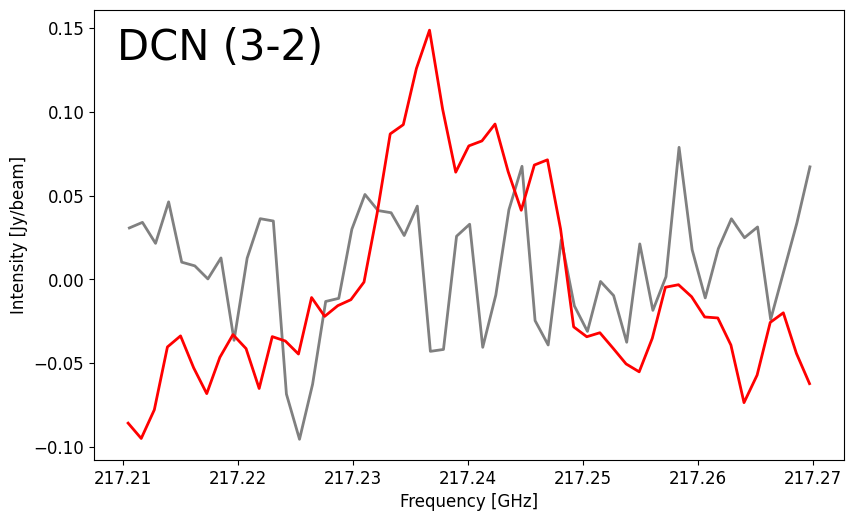

In [183]:
## View all spectra
#func.plot_spectra(newf_array/1e9, summed_intensity, figsize=(8,6), color='black')
#func.plot_spectra(freq_array/1e9, sum_inten_noshift, figsize=(8,6), color='black')

## View specific range
freqGHz_start = 217.21
freqGHz_end   = 217.27

freq_startpix = np.searchsorted(newf_array, freqGHz_start*1e9)
freq_endpix   = np.searchsorted(newf_array, freqGHz_end*1e9)

freq_start_no = np.searchsorted(-freq_array, -freqGHz_end*1e9) #due to the descending array
freq_end_no   = np.searchsorted(-freq_array, -freqGHz_start*1e9)

#print(freq_startpix, freq_endpix)
#print(freq_start_no, freq_end_no)

# Plot
sliced_f    = newf_array[freq_startpix:freq_endpix]/ 1e9
sliced_f_no = freq_array[freq_start_no:freq_end_no]/ 1e9
sliced_inten = summed_intensity[freq_startpix:freq_endpix]
sliced_inten_noshift = sum_inten_noshift[freq_start_no:freq_end_no]

fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.xlabel('Frequency [GHz]', size = 12)
plt.ylabel('Intensity [Jy/beam]', size = 12)

plt.plot(sliced_f_no, sliced_inten_noshift, '-', color='grey', linewidth = 2.0)
plt.plot(sliced_f, sliced_inten ,'-', color='red', linewidth = 2.0)

plt.text(0.03, 0.87, 'DCN (3-2)', 
         verticalalignment = 'bottom', horizontalalignment = 'left',
         color='black', transform = ax.transAxes, fontsize=30)

#plt.legend(loc=1, fontsize = 10)

#sig = 3 * 0.0018148618
#plt.axhline(y=sig, color=(0.7,0.7,0.2, 0.3), linestyle='--',linewidth=1)
#plt.axvline(x=217.238, color=(0.7,0.7,0.2, 0.3), linestyle='--',linewidth=1)
#plt.axvline(x=217.10498, color=(0.7,0.7,0.2, 0.3), linestyle='--',linewidth=1)

#plt.savefig('Stack35_0.png', bbox_inches='tight')

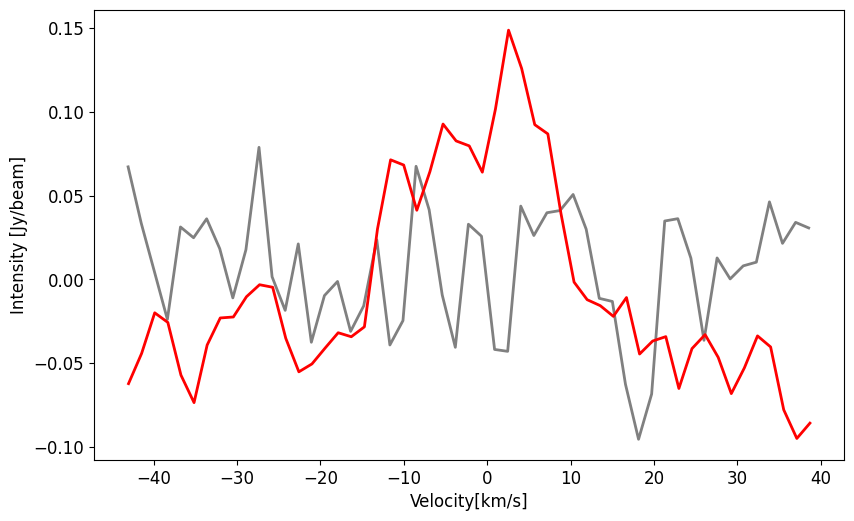

In [181]:
sliced_v = c * (1 - (sliced_f*1e9) / restfreq)
sliced_v_no = c * (1 - (sliced_f_no*1e9) / restfreq)

fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
#ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.xlabel('Velocity[km/s]', size = 12)
plt.ylabel('Intensity [Jy/beam]', size = 12)

plt.plot(sliced_v_no/1e3, sliced_inten_noshift, '-', color='grey', linewidth = 2.0)
plt.plot(sliced_v/1e3, sliced_inten,'-', color='red', linewidth = 2.0)

### (Modifications needed)

In [ ]:
## Stack the spectra and plot it
sum_intensity = s.stack_spectra(verbose = False)

In [ ]:
data = pickle.load(open('cube.pickle','rb'))
data_decomposed = pickle.load(open('cube_decomposed.pickle','rb'))

for i in range(len(data_decomposed['means_fit'])): # i = pixel number(not components in each pixel)

    try:
        max_index = np.argmax(data_decomposed['amplitudes_fit'][i]) #Find the highest peak
        freq_fit = data_decomposed['means_fit'][i][max_index]
        print(freq_fit)
    except:
        print('Failed to fit.')
        
    
    intensity_array = data['data_list'][i]
    shift_freq, delta_freq = s.unrbshift_spectra( freq_array = freq_array,
                                                  velocity_array  = velocity_array,
                                                  centroid_freq   = freq_fit,
                                                  rest_freq = restfreq )

    #rest = freq_fit - delta_freq/1e9
    #func.plot_spectra(shift_freq/1e9, intensity_array,figsize=(8,6))

# produce the frequency array removing Doppler shift. 
#shift_freq = restfreq * (1 - shift_velo / c)
#func.plot_spectra(shift_freq/1e9,intensity_array, figsize=(6,4))


In [ ]:
## Plot the shifted spectra with fitting result
data = pickle.load(open('cube.pickle','rb'))
data_decomposed = pickle.load(open('cube_decomposed.pickle','rb'))

#print(data_decomposed['means_fit'])
for index in range(len(data_decomposed['means_fit'])): # index = pixel number(not components in each pixel)
        # original data
        x   = shift_freq / 1e9
        y   = data['data_list'][index]
        pix = data['location'][index]
        
        # Fitting parameter
        fit_fwhms = data_decomposed['fwhms_fit'][index]
        fit_means = data_decomposed['means_fit'][index]
        fit_amps  = data_decomposed['amplitudes_fit'][index]
        #print(fit_amps)
        #print(fit_means)
   
        fig = plt.figure()
        ax  = fig.add_axes([0.12, 0.1, 0.75, 0.75])
        
        fitcolor  = (0.8, 0.1, 0.3, 0.8)
        datacolor = (0.3,0.5,0.8, 0.5) 
        
        if len(fit_amps) > 0.:
            for j in range(len(fit_amps)):
                amp, fwhm, mean =  fit_amps[j], fit_fwhms[j], fit_means[j]
                delta_freq = freq_fit * 1e9 - restfreq 
                shift_mean = mean - delta_freq/1e9
                yy = amp * np.exp(-4. * np.log(2) * (x-shift_mean)**2 / fwhm**2)
                plt.plot(x, yy, '-', lw=1.5, color=fitcolor)
        
        xpix = pix[0]
        ypix = pix[1]
    
        xlabel = 'Frequency [GHz]'    
        xlabel_size = 12
        ylabel = 'Intensity [Jy/beam]'
        ylabel_size = 12
        fontsize = 12
                
        plt.plot(x, y, color= datacolor)
        #ax.set_xlim(0,1532)
        #plt.xlabel('Velocity[km/s]')
        plt.xlabel(xlabel, size = xlabel_size)
        plt.ylabel(ylabel, size = ylabel_size)
        
        plt.legend(loc=1, fontsize = fontsize)
        
        plt.show()

### Plot the specific frequency range

In [ ]:
freqGHz_start = 231.50
freqGHz_end   = 231.75

#print(shift_freq/1e9)
array_type = 'incre'

if array_type == 'des':
    freq_startpix = np.searchsorted(-freq_array, -freqGHz_end*1e9) #due to the descending array
    freq_endpix   = np.searchsorted(-freq_array, -freqGHz_start*1e9)
    
elif array_type == 'incre':
    freq_startpix = np.searchsorted(freq_array, freqGHz_start*1e9) #due to the descending array
    freq_endpix   = np.searchsorted(freq_array, freqGHz_end*1e9)



print(freq_startpix, freq_endpix)

intensity_array = cube[0][:, 242, 125]
func.plot_spectra(freq_array,intensity_array,figsize=(9,6))

# Plot the spectra with specific range
sliced_freq = freq_array[freq_startpix:freq_endpix]/1e9
sliced_intensity = intensity_array[freq_startpix:freq_endpix]

func.plot_spectra(sliced_freq, sliced_intensity,figsize=(9,6))

std = np.std(sliced_intensity)
print('standard deviation: ', std) 